In [ ]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0  12248      0 --:--:-- --:--:-- --:--:-- 12248
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 369.7MB 48kB/s 
+ set +ex
Installation succeeded!


In [ ]:
import os

import numpy as np

import chainer
from chainer import cuda
import chainer.functions as F
import chainer.links as L
from chainer import Variable
from chainer.training import extensions


chainer.print_runtime_info()

/usr/local/lib/python3.7/dist-packages/chainer/backends/cuda.py:147: UserWarning: cuDNN is not enabled.
Please reinstall CuPy after you install cudnn
(see https://docs-cupy.chainer.org/en/stable/install.html#install-cudnn).
  'cuDNN is not enabled.\n'


Platform: Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic
Chainer: 7.4.0
ChainerX: Not Available
NumPy: 1.19.5
CuPy:
  OS                           : Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic
  CuPy Version                 : 8.5.0
  NumPy Version                : 1.19.5
  SciPy Version                : 1.4.1
  Cython Build Version         : 0.29.22
  CUDA Root                    : /usr/local/cuda
  CUDA Build Version           : 10000
  CUDA Driver Version          : 11020
  CUDA Runtime Version         : 10000
  cuBLAS Version               : 10000
  cuFFT Version                : 10000
  cuRAND Version               : 10000
  cuSOLVER Version             : (10, 0, 0)
  cuSPARSE Version             : 10000
  NVRTC Version                : (10, 0)
  Thrust Version               : 100903
  CUB Build Version            : 100800
  cuDNN Build Version          : 7605
  cuDNN Version                : 7605
  NCCL Build Version           : 2604
  NCCL Runtime Version         : 2604
  cu

In [ ]:
# parameters
n_epoch = 10  # number of epochs
n_hidden = 100  # number of hidden units
batchsize = 50  # minibatch size
snapshot_interval = 10000  # number of iterations per snapshots
display_interval = 100  # number of iterations per display the status
gpu_id = 0
out_dir = 'result'
seed = 0  # random seed


In [ ]:
# Load the CIFAR10 dataset if args.dataset is not specified
train, _ = chainer.datasets.get_cifar10(withlabel=False, scale=255.)

In [ ]:

train_iter = chainer.iterators.SerialIterator(train, batchsize)

In [ ]:
class Generator(chainer.Chain):

    def __init__(self, n_hidden, bottom_width=4, ch=512, wscale=0.02):
        super(Generator, self).__init__()
        self.n_hidden = n_hidden
        self.ch = ch
        self.bottom_width = bottom_width

        with self.init_scope():
            w = chainer.initializers.Normal(wscale)
            self.l0 = L.Linear(self.n_hidden, bottom_width * bottom_width * ch,
                               initialW=w)
            self.dc1 = L.Deconvolution2D(ch, ch // 2, 4, 2, 1, initialW=w)
            self.dc2 = L.Deconvolution2D(ch // 2, ch // 4, 4, 2, 1, initialW=w)
            self.dc3 = L.Deconvolution2D(ch // 4, ch // 8, 4, 2, 1, initialW=w)
            self.dc4 = L.Deconvolution2D(ch // 8, 3, 3, 1, 1, initialW=w)
            self.bn0 = L.BatchNormalization(bottom_width * bottom_width * ch)
            self.bn1 = L.BatchNormalization(ch // 2)
            self.bn2 = L.BatchNormalization(ch // 4)
            self.bn3 = L.BatchNormalization(ch // 8)

    def make_hidden(self, batchsize):
        return np.random.uniform(-1, 1, (batchsize, self.n_hidden, 1, 1)).astype(np.float32)

    def __call__(self, z):
        h = F.reshape(F.relu(self.bn0(self.l0(z))),
                                (len(z), self.ch, self.bottom_width, self.bottom_width))
        h = F.relu(self.bn1(self.dc1(h)))
        h = F.relu(self.bn2(self.dc2(h)))
        h = F.relu(self.bn3(self.dc3(h)))
        x = F.sigmoid(self.dc4(h))
        return x

In [ ]:
class Discriminator(chainer.Chain):

    def __init__(self, bottom_width=4, ch=512, wscale=0.02):
        w = chainer.initializers.Normal(wscale)
        super(Discriminator, self).__init__()
        with self.init_scope():
            self.c0_0 = L.Convolution2D(3, ch // 8, 3, 1, 1, initialW=w)
            self.c0_1 = L.Convolution2D(ch // 8, ch // 4, 4, 2, 1, initialW=w)
            self.c1_0 = L.Convolution2D(ch // 4, ch // 4, 3, 1, 1, initialW=w)
            self.c1_1 = L.Convolution2D(ch // 4, ch // 2, 4, 2, 1, initialW=w)
            self.c2_0 = L.Convolution2D(ch // 2, ch // 2, 3, 1, 1, initialW=w)
            self.c2_1 = L.Convolution2D(ch // 2, ch // 1, 4, 2, 1, initialW=w)
            self.c3_0 = L.Convolution2D(ch // 1, ch // 1, 3, 1, 1, initialW=w)
            self.l4 = L.Linear(bottom_width * bottom_width * ch, 1, initialW=w)
            self.bn0_1 = L.BatchNormalization(ch // 4, use_gamma=False)
            self.bn1_0 = L.BatchNormalization(ch // 4, use_gamma=False)
            self.bn1_1 = L.BatchNormalization(ch // 2, use_gamma=False)
            self.bn2_0 = L.BatchNormalization(ch // 2, use_gamma=False)
            self.bn2_1 = L.BatchNormalization(ch // 1, use_gamma=False)
            self.bn3_0 = L.BatchNormalization(ch // 1, use_gamma=False)

    def __call__(self, x):
        h = add_noise(x)
        h = F.leaky_relu(add_noise(self.c0_0(h)))
        h = F.leaky_relu(add_noise(self.bn0_1(self.c0_1(h))))
        h = F.leaky_relu(add_noise(self.bn1_0(self.c1_0(h))))
        h = F.leaky_relu(add_noise(self.bn1_1(self.c1_1(h))))
        h = F.leaky_relu(add_noise(self.bn2_0(self.c2_0(h))))
        h = F.leaky_relu(add_noise(self.bn2_1(self.c2_1(h))))
        h = F.leaky_relu(add_noise(self.bn3_0(self.c3_0(h))))
        return self.l4(h)

In [ ]:
def add_noise(h, sigma=0.2):
    xp = cuda.get_array_module(h.data)
    if chainer.config.train:
        return h + sigma * xp.random.randn(*h.shape)
    else:
        return h

In [ ]:
gen = Generator(n_hidden=n_hidden)
dis = Discriminator()

In [ ]:
# Setup an optimizer
def make_optimizer(model, alpha=0.0002, beta1=0.5):
    optimizer = chainer.optimizers.Adam(alpha=alpha, beta1=beta1)
    optimizer.setup(model)
    optimizer.add_hook(
        chainer.optimizer_hooks.WeightDecay(0.0001), 'hook_dec')
    return optimizer

In [ ]:

opt_gen = make_optimizer(gen)
opt_dis = make_optimizer(dis)

In [ ]:
class DCGANUpdater(chainer.training.updaters.StandardUpdater):

    def __init__(self, *args, **kwargs):
        self.gen, self.dis = kwargs.pop('models')
        super(DCGANUpdater, self).__init__(*args, **kwargs)

    def loss_dis(self, dis, y_fake, y_real):
        batchsize = len(y_fake)
        L1 = F.sum(F.softplus(-y_real)) / batchsize
        L2 = F.sum(F.softplus(y_fake)) / batchsize
        loss = L1 + L2
        chainer.report({'loss': loss}, dis)
        return loss

    def loss_gen(self, gen, y_fake):
        batchsize = len(y_fake)
        loss = F.sum(F.softplus(-y_fake)) / batchsize
        chainer.report({'loss': loss}, gen)
        return loss

    def update_core(self):
        gen_optimizer = self.get_optimizer('gen')
        dis_optimizer = self.get_optimizer('dis')

        batch = self.get_iterator('main').next()
        x_real = Variable(self.converter(batch, self.device)) / 255.
        xp = chainer.backends.cuda.get_array_module(x_real.data)

        gen, dis = self.gen, self.dis
        batchsize = len(batch)

        y_real = dis(x_real)

        z = Variable(xp.asarray(gen.make_hidden(batchsize)))
        x_fake = gen(z)
        y_fake = dis(x_fake)

        dis_optimizer.update(self.loss_dis, dis, y_fake, y_real)
        gen_optimizer.update(self.loss_gen, gen, y_fake)

In [ ]:
updater = DCGANUpdater(
      models=(gen, dis),
      iterator=train_iter,
      optimizer={
          'gen': opt_gen, 'dis': opt_dis},
      device=gpu_id)
trainer = chainer.training.Trainer(updater, (n_epoch, 'epoch'), out=out_dir)

In [ ]:
from PIL import Image
import chainer.backends.cuda


def out_generated_image(gen, dis, rows, cols, seed, dst):
    @chainer.training.make_extension()
    def make_image(trainer):
        np.random.seed(seed)
        n_images = rows * cols
        xp = gen.xp
        z = Variable(xp.asarray(gen.make_hidden(n_images)))
        with chainer.using_config('train', False):
            x = gen(z)
        x = chainer.backends.cuda.to_cpu(x.data)
        np.random.seed()

        x = np.asarray(np.clip(x * 255, 0.0, 255.0), dtype=np.uint8)
        _, _, H, W = x.shape
        x = x.reshape((rows, cols, 3, H, W))
        x = x.transpose(0, 3, 1, 4, 2)
        x = x.reshape((rows * H, cols * W, 3))

        preview_dir = '{}/preview'.format(dst)
        preview_path = preview_dir +\
            '/image{:0>8}.png'.format(trainer.updater.iteration)
        if not os.path.exists(preview_dir):
            os.makedirs(preview_dir)
        Image.fromarray(x).save(preview_path)
    return make_image

In [ ]:
snapshot_interval = (snapshot_interval, 'iteration')
display_interval = (display_interval, 'iteration')
trainer.extend(
    extensions.snapshot(filename='snapshot_iter_{.updater.iteration}.npz'),
    trigger=snapshot_interval)
trainer.extend(extensions.snapshot_object(
    gen, 'gen_iter_{.updater.iteration}.npz'), trigger=snapshot_interval)
trainer.extend(extensions.snapshot_object(
    dis, 'dis_iter_{.updater.iteration}.npz'), trigger=snapshot_interval)
trainer.extend(extensions.LogReport(trigger=display_interval))
trainer.extend(extensions.PrintReport([
    'epoch', 'iteration', 'gen/loss', 'dis/loss',
]), trigger=display_interval)
trainer.extend(extensions.ProgressBar(update_interval=100))
trainer.extend(
    out_generated_image(
        gen, dis,
        10, 10, seed, out_dir),
    trigger=snapshot_interval)

In [ ]:

# Run the training
trainer.run()

epoch       iteration   gen/loss    dis/loss  
0           100         1.36197     1.72332     
     total [..................................................]  1.00%
this epoch [#####.............................................] 10.00%
       100 iter, 0 epoch / 10 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
0           200         1.0022      1.40847     
     total [#.................................................]  2.00%
this epoch [##########........................................] 20.00%
       200 iter, 0 epoch / 10 epochs
    6.8007 iters/sec. Estimated time to finish: 0:24:01.023169.
0           300         0.881626    1.37447     
     total [#.................................................]  3.00%
this epoch [###############...................................] 30.00%
       300 iter, 0 epoch / 10 epochs
    6.7488 iters/sec. Estimated time to finish: 0:23:57.300344.
0           400         0.859557    1.40394     
     total [##.....................

In [ ]:
%%bash
ls result/preview

image00010000.png


In [ ]:
from IPython.display import Image, display_png
import glob

image_files = sorted(glob.glob(out_dir + '/preview/*.png'))

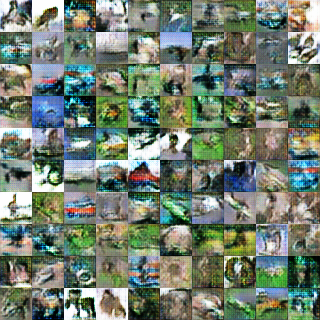

In [ ]:
display_png(Image(image_files[0]))  #  snapshot